# Spectral Clustering


In this exercise, you will implement spectral clustering and try it on diffent kinds of data, for instance:

* N-blob: Random points in $\mathbb{R}^2$ according to N Gaussian distributions with different means;

* Two moons: Random points shaped as two intertwined moons;

* Point and circle: random points from a concentrated Gaussian point in the middle and a wide circle around it.

The first step after generating the data is to construct a graph and, for that, we need a similarity function. In this exercise we will use the following similarity:

$$
d(x_i, x_j) = \exp\left(-\frac{||x_i-x_j||_2^2}{2\sigma^2}\right)
$$

Using this similarity, we can compute the weight matrix W representing the graph, compute the graph Laplacian L and finally use its eigenvectors for clustering.


## Setup

In [ ]:
from generate_data import worst_case_blob, blobs, two_moons, point_and_circle
from utils import plot_clusters, min_span_tree, plot_graph_matrix, min_span_tree
from utils import plot_clustering_result, plot_the_bend, plot_edges_and_points
from sklearn.cluster import KMeans
import sklearn.metrics as skm
import numpy as np
from skimage import io
import numpy as np
import matplotlib.pyplot as plt
import os

import scipy
import numpy as np

## Generating the data

I try the worst_case_blob, point_and_circle and blobs.


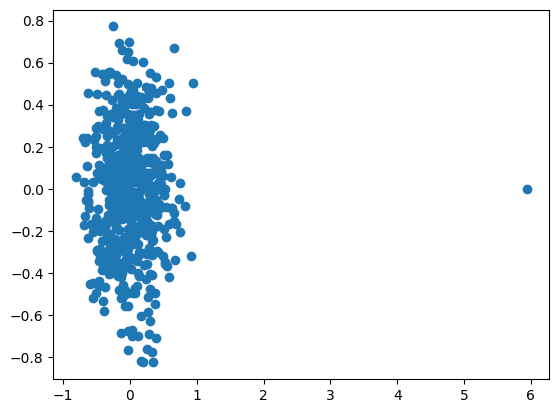

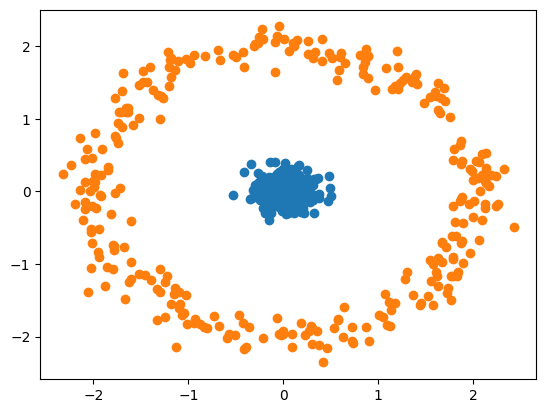

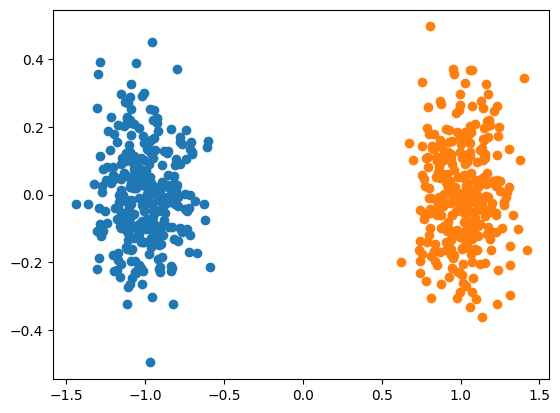

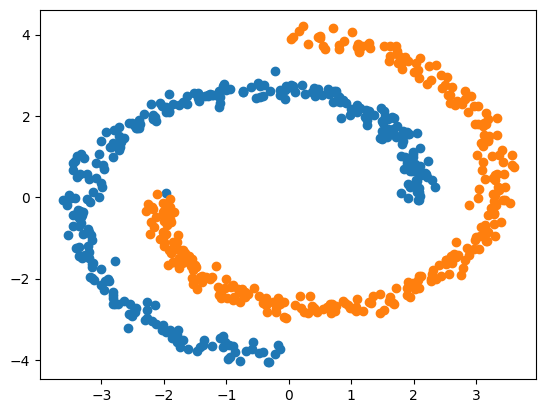

In [ ]:
# Example

for fn in [worst_case_blob]:
    X, Y = fn(num_samples=600)
    plot_clusters(X, Y, fignum=str(fn))

for fn in [point_and_circle]:
    X, Y = fn(num_samples=600)
    plot_clusters(X, Y, fignum=str(fn))

for fn in [blobs]:
    X, Y = fn(num_samples=600)
    plot_clusters(X, Y, fignum=str(fn))

for fn in [two_moons]:
    X, Y = fn(num_samples=600)
    plot_clusters(X, Y, fignum=str(fn))

# You can check the documentation of each function to see the optional parameters, e.g.:worst_case_blob?

## Building similarity graph

In the utils.py file I change the line 49 G=nx.from_numpy_matrix(W) by G=nx.from_numpy_array(W) for compatibility reasons.

In [ ]:
def build_similarity_graph(X, var=1.0, eps=0.0, k=0):
    """
    TO BE COMPLETED.

    Computes the similarity matrix for a given dataset of samples.
    If k=0, builds epsilon graph.
    Otherwise, builds kNN graph.

    Parameters
    ----------
    X : numpy array
        (n x m) matrix of m-dimensional samples
    var : double
        the sigma value for the exponential function, already squared
    eps : double
        threshold for epsilon graphs
    k : int
        The number of neighbours k for k-nn. If zero, use epsilon-graph

    Returns
    -------
        W: (n x n) dimensional matrix representing the weight matrix of the graph
    """
    n = X.shape[0]
    W = np.zeros((n, n))

    """
    Build similarity graph, before threshold or kNN
    similarities: (n x n) matrix with similarities between all possible couples of points.
    The similarity function is d(x,y)=exp(-||x-y||^2/(2*var))
    """

    similarities = np.exp(
        -np.linalg.norm(X[None, :, :] - X[:, None, :], axis=-1) ** 2 / (2 * var)
    )

    # If epsilon graph
    if k == 0:
        """
        compute an epsilon graph from the similarities
        for each node x_i, an epsilon graph has weights
        w_ij = d(x_i,x_j) when w_ij >= eps, and 0 otherwise
        """
        mask = similarities >= eps
        W[mask] = similarities[mask]
        pass

    # If kNN graph
    elif k != 0:
        """
        compute a k-nn graph from the similarities
        for each node x_i, a k-nn graph has weights
        w_ij = d(x_i,x_j) for the k closest nodes to x_i, and 0
        for all the k-n remaining nodes
        Remember to remove self similarity and
        make the graph undirected
        """
        pass

        similarities -= np.diag(np.diag(similarities))
        for i in range(n):
            closest_points = np.argsort(similarities[i])[::-1][:k]
            W[i, closest_points] = similarities[i, closest_points]
        # for a symmetric W
        W += W.T

    return W


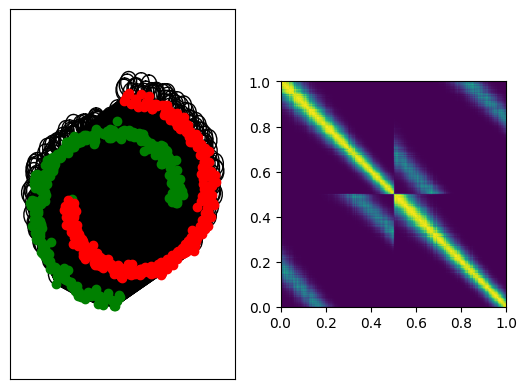

In [ ]:
# Example

W = build_similarity_graph(X)
W[0, 599] = 1    # add two placeholder edges to reproduce example picture
W[10, 500] = 1   #


plot_graph_matrix(X, Y, W)  # shows the graph and the visualization of W

## Computing the Laplacian

In [ ]:
def build_laplacian(W, laplacian_normalization='unn'):
    """
    Compute graph Laplacian.

    Parameters
    ----------
    W : numpy array
        Adjacency matrix (n x n)
    laplacian_normalization : str
        String selecting which version of the laplacian matrix to construct.
            'unn':  unnormalized,
            'sym': symmetric normalization
            'rw':  random-walk normalization

    Returns
    -------
    L: (n x n) dimensional matrix representing the Laplacian of the graph
    """
    #L = np.zeros(W.shape)
    n = W.shape[0]
    D = np.diag(np.sum(W, axis=1))
    if laplacian_normalization == "unn":
        L = D - W
    elif laplacian_normalization == "sym":
        D_inv_sqrt = np.sqrt(np.linalg.inv(D))
        L = np.eye(n) - D_inv_sqrt @ W @ D_inv_sqrt
    elif laplacian_normalization == "rw":
        D_inv = np.linalg.inv(D)
        L = np.eye(n) - D_inv @ W
    return L
    # for example (unnormalized): L = D - W

## Clustering

I use the elbow rule: The number of eigenvalue to use is equal to the
indice for which we have the first biggest  from 0 to a strict positive value.

In [ ]:
#Function that choose the indices of the eigenvalues that we use for clustering.

def spectral_clustering(L, chosen_eig_indices=None, num_classes=2):
    """
    Parameters
    ----------
    L : numpy array
        Graph Laplacian (standard or normalized)
    choosen_eig_indices : list or None
        Indices of eigenvectors to use for clustering.
        If None, use adaptive choice of eigenvectors.
    num_classes : int
        Number of clusters to compute (defaults to 2)


    Returns
    -------
    Y : numpy array (num_samples, )
        Cluster assignments
    """

    """
    Use the function scipy.linalg.eig or the function scipy.sparse.linalg.eigs to compute:
    U = (n x n) eigenvector matrix           (sorted)
    E = (n x n) eigenvalue diagonal matrix   (sorted)
    """
    """
    compute the clustering assignment from the eigenvectors
    Y = (n x 1) cluster assignments in [0,1,...,num_classes-1]
    """
    E, U = scipy.linalg.eig(L,)
    indices = np.argsort(E.real)
    U = U[:, indices].real
    E = E[indices].real
    #Choose eigenvalues:
    epsilon=0.000001
    if chosen_eig_indices == None:
      chosen_eig_indices=np.where(E<epsilon)[0]

    """
    compute the clustering assignment from the eigenvectors
    Y = (n x 1) cluster assignments in [0,1,...,num_classes-1]
    """
    # Y = np.zeros(L.shape[0])
    kmeans = KMeans(n_init='auto', n_clusters=num_classes)
    Y = kmeans.fit_predict(U[:, chosen_eig_indices].real)
    return Y

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


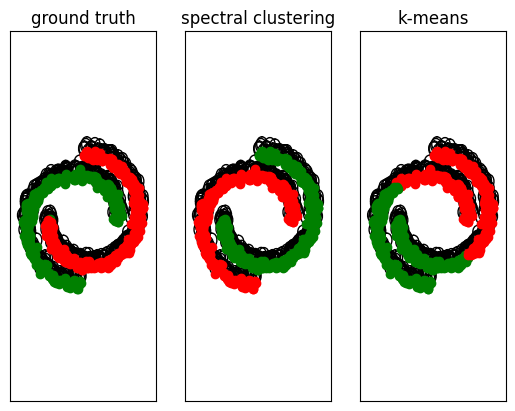

In [ ]:
# Example

num_classes = 2
W=build_similarity_graph(X,k=10)
L = build_laplacian(W)
Y_rec = spectral_clustering(L, chosen_eig_indices=None, num_classes=num_classes)

# Plot results, comparing to KMeans
plot_clustering_result(X, Y, L, Y_rec, KMeans(num_classes).fit_predict(X))

## Parameter sensitivity

Here I played with parameters and I changed de variance from $1$ to $10$. This gives me better performance for image segmentation.
I also print de $\epsilon$ value corresponding to the max performance.
I used these values (var, $\epsilon$) for the segmentation.

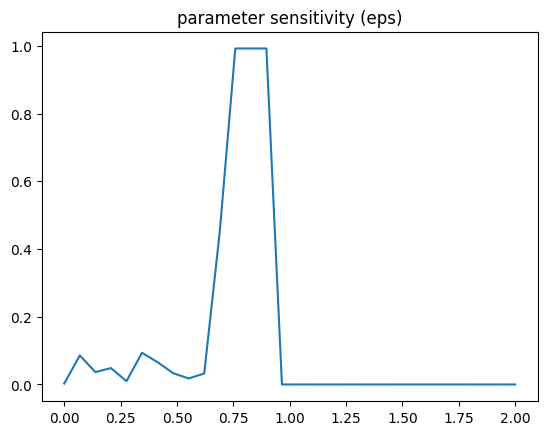

The corresponding epsilon value is 0.759


In [ ]:
def parameter_sensitivity(parameter_type='eps'):
    """
    TO BE COMPLETED.

    A function to test spectral clustering sensitivity to parameter choice.
    """
    # the number of samples to generate
    num_samples = 500

    """
    Choose parameters
    """
    var = 10.0  # exponential_euclidean's sigma^2
    laplacian_normalization = 'unn'
    chosen_eig_indices = None

    """
    Choose candidate parameters
    """
    if parameter_type == 'eps':
      parameter_candidate = np.linspace(0, 2, 30)  # the epsilon threshold (if 'eps')
    else:
      parameter_candidate = list(range(1, 100, 3)) # the number of neighbours for the graph (if 'k')
    parameter_performance = []


    #parameter_type = 'eps' # choose between 'k' or 'eps'
    #parameter_candidate = [1, 2]  # the number of neighbours for the graph (if 'k')
                                  # or the epsilon threshold (if 'eps')
    #parameter_performance = [2,3,4,4]

    for parameter in parameter_candidate:
        # Generate data
        X, Y = two_moons(num_samples, 1, 0.02)
        num_classes = len(np.unique(Y))

        parameter_wrap = {parameter_type: parameter}

        W = build_similarity_graph(X, **parameter_wrap)
        L = build_laplacian(W, laplacian_normalization)

        Y_rec = spectral_clustering(L, chosen_eig_indices, num_classes)

        parameter_performance += [skm.adjusted_rand_score(Y, Y_rec)]
    max_value=max(parameter_candidate, key= lambda x: parameter_performance[list(parameter_candidate).index(x)])
    plt.figure()
    plt.plot(parameter_candidate, parameter_performance)
    plt.title(f'parameter sensitivity ({parameter_type})')
    plt.show()
    print(f'The corresponding epsilon value is {round(max_value,3)}')
parameter_sensitivity()


## Image segmentation

In [ ]:
def image_segmentation(input_img='/content/four_elements.bmp',k=2,num_classes = 5):
    """
    TO BE COMPLETED

    Function to perform image segmentation.

    :param input_img: name of the image file in /data (e.g. 'four_elements.bmp' or 'fruit_salad.bmp')
    """
    filename = os.path.join('data', input_img)

    X = io.imread(filename)
    X = (X - np.min(X)) / (np.max(X) - np.min(X))

    im_side = np.size(X, 1)
    Xr = X.reshape(im_side ** 2, 3)
    """
    Y_rec should contain an index from 0 to c-1 where c is the
     number of segments you want to split the image into
    """

    """
    Choose parameters
    """
    var = 1 #was 1
    k = 0 #To have an epsilon graph #2
    laplacian_normalization = 'unn'
    chosen_eig_indices = [1,2,3]
    num_classes = 5
    epsilon=0.759 #given by the figure above

    W = build_similarity_graph(Xr, var=var, eps=epsilon, k=k)
    L = build_laplacian(W, laplacian_normalization)
    Y_rec = spectral_clustering(L,chosen_eig_indices, num_classes=num_classes)

    plt.figure()

    plt.subplot(1, 2, 1)
    plt.imshow(X)

    plt.subplot(1, 2, 2)
    Y_rec = Y_rec.reshape(im_side, im_side)
    plt.imshow(Y_rec)

    plt.show()

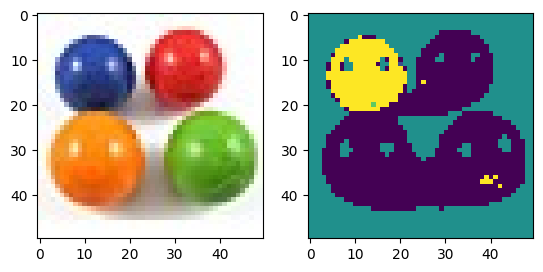

In [ ]:
image_segmentation()

# Questions

### Q1.1: What is the purpose of the option parameter in `worst_case_blob`?

The parameter $δ$ specifies the distance of the outlier from $N(0,\sigma)$.
For example, in the case $\delta=500$ we can see that the outlier is at a distance of $500$ from the normal distribution.

In [ ]:
help(worst_case_blob)

Help on function worst_case_blob in module generate_data:

worst_case_blob(num_samples, delta=5)
    Generates a single blob.
    
    :param num_samples: number of samples to create in the blob
    :param delta:
    :return: X,  (num_samples, 2) matrix of 2-dimensional samples
             Y,  (num_samples, ) vector of "true" cluster assignment



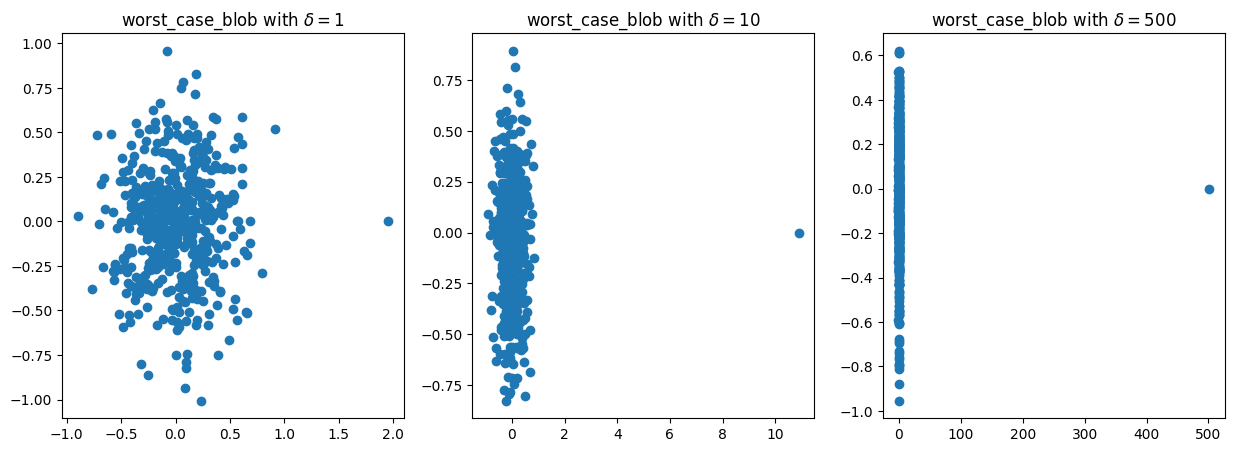

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for index, delta in enumerate([1, 10, 500]):
    X, Y = worst_case_blob(500, delta=delta)
    axs[index].plot(X[:, 0], X[:, 1], "o")
    axs[index].set_title(rf"worst_case_blob with $\delta={{{delta}}}$")

### Q1.2: While varying the parameter of `worst_case_blob`, try to select a value of $\epsilon$ that keeps the graph connected (the function `min_span_tree` can help you). What happens? Can you tell when it is a bad idea to use this approach?

The idea is to use minimum spanning tree to obtain $ɛ$, which ensure (by construction) that the $ɛ$ graph will stay connected.

First I generate the data with worst_case_blob function for different values of $\delta$. For a given $\delta$, I create a similarity graph, then I calculate the minimimum spanning tree (MST). I choose $ɛ$ as the smallest weight in MST.
Given this $ɛ$ I create an $ɛ$-graph.

---



Finally I calculate the purcentage of removed edges to analyse and I check if the graph is connected.  

Delta = 0.12
    Epsilon = 0.9449546221903005
The graph is connected 
    Percentage of removed edges: 74.218%
Delta = 0.2
    Epsilon = 0.9534667705801787
The graph is connected 
    Percentage of removed edges: 77.806%
Delta = 0.7
    Epsilon = 0.768834382198836
The graph is connected 
    Percentage of removed edges: 22.09%
Delta = 2
    Epsilon = 0.07831686752656263
The graph is connected 
    Percentage of removed edges: 0.398%


Text(0.5, 1.0, 'Removed percentage with respect to delta values')

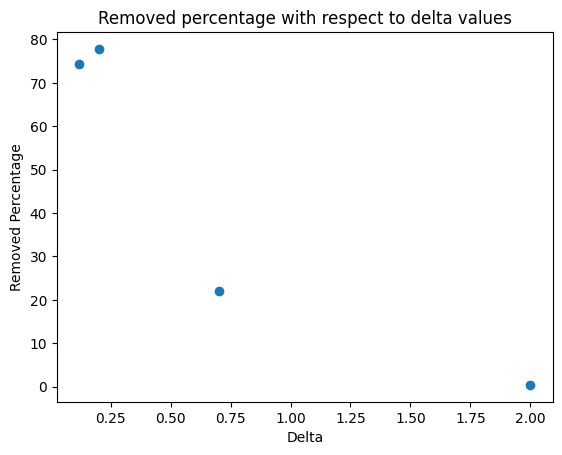

In [ ]:
def is_connected(graph):
  num_nodes=len(graph)
  visited=[False]*num_nodes
  def dfs(node):
    visited[node]=True
    for i in range(num_nodes):
      if graph[node][i]!=0 and not visited[i]:
        dfs(i)
  dfs(0)
  return all(visited)

delta_values = [0.12, 0.20, 0.7, 2]
Removed=[]
for delta in delta_values:
    print(f'Delta = {delta}')

    #Generate Data
    num_samples = 500
    X, Y = worst_case_blob(num_samples, delta)

    #I Calculate the weight for fully connected graph
    W_full = build_similarity_graph(X) #from data to graph
    minimum_spanning_tree = W_full * min_span_tree(-W_full) #MST

    #Epsilon calculation
    epsilon = np.min(minimum_spanning_tree[minimum_spanning_tree > 0]) #positivity critearion
    print(f'    Epsilon = {epsilon}')
    W_epsilon = build_similarity_graph(X, eps=epsilon)

    #connectivity check
    graph_connected=is_connected(W_epsilon)
    print(f"The graph is {'connected 'if graph_connected else 'not connected'}")

    # Edges number calculations
    num_edges_full = np.count_nonzero(W_full) // 2
    num_edges_epsilon = np.count_nonzero(W_epsilon) // 2
    percentage_removed = 100 * (num_edges_full - num_edges_epsilon) / num_edges_full
    Removed.append(percentage_removed)
    print(f'    Percentage of removed edges: {np.round(percentage_removed, 3)}%')

#plotting section
plt.figure()
plt.plot(delta_values, Removed, 'o')
plt.xlabel('Delta')
plt.ylabel('Removed Percentage')
plt.title("Removed percentage with respect to delta values")


Analysis:
The greater the delta, the smaller the number of stops removed, but the greater the delta, the more outliers (see previous question), so we can assume that this method is not stable with outliers.
We canc conclude that, this is a bad idea to use when the data is to much noisy.

### Q1.3: Is it important to build a connected graph? Compare k-NN to $\epsilon$-graphs with respect to the difficulty of building a connected graph.

Yes it is important to build connected graph. In fact, using graph cut method for image clustering or other type of problem is easier on connected graph.

We can see that with the given "blob" set, the $k-NN$ method gives (for any $k\leq N_{sample}$, where $N_{sample}$ denotes the number of samples\cluster  in the "blob" set) an unconnected graph. Whereas for the $ɛ$-graph it's the other way around, we get a connected graph.

For the "worst_case_blob" case, which can be assimilated to noisy data, we can see that $k-NN$ gives a connected graph where $ɛ$-graph is not (even if $ɛ$ is very small).

Here is the separate Blobs Example: diconected case


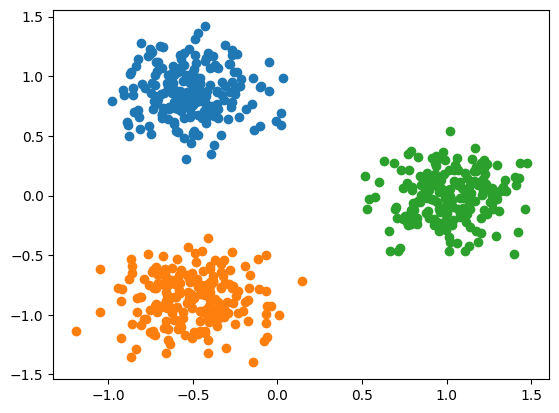

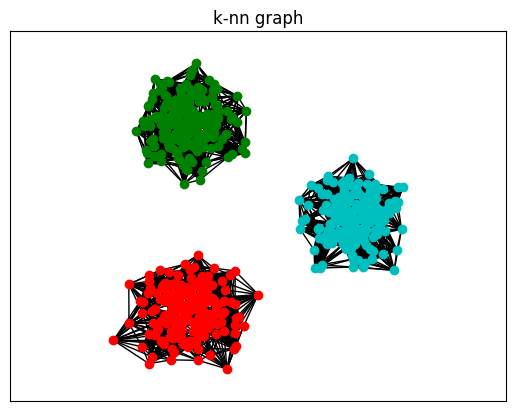

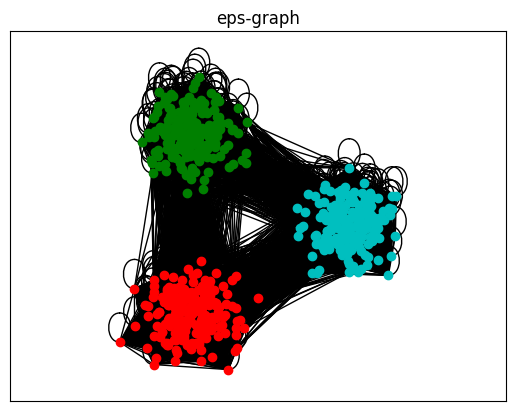

Worst_case_blob Example with delta =3: 


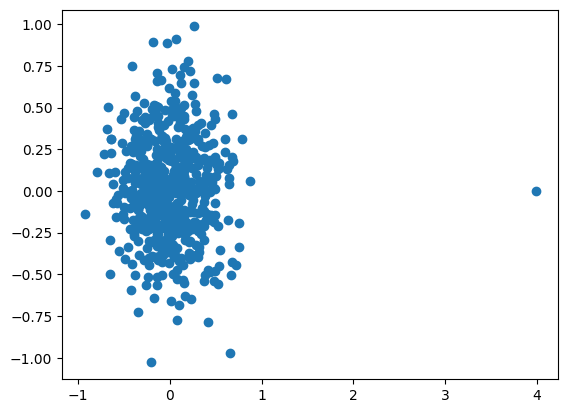

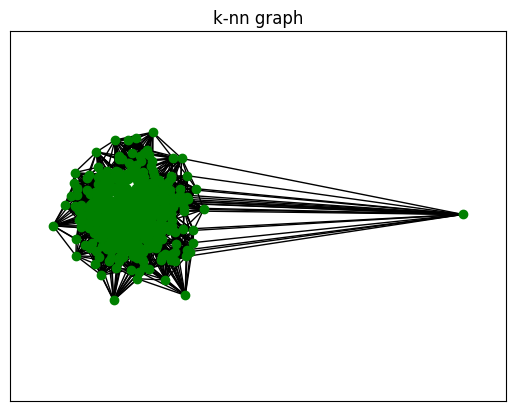

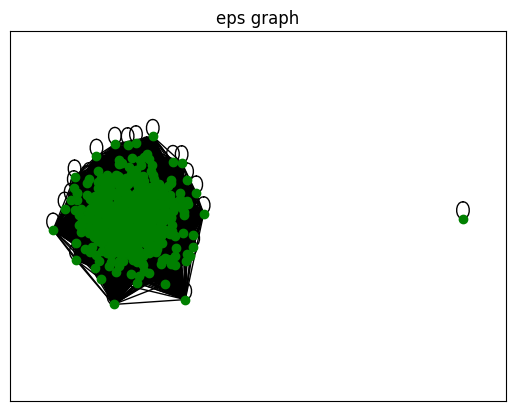

In [ ]:
print("Here is the separate Blobs Example: diconected case")

# Generate and plot clusters for separate blobs
X, Y = blobs(600, n_blobs=3, blob_var=0.2)
plot_clusters(X, Y)
plt.show()

# Visualize k-NN graphs for different k values
plt.figure()
W = build_similarity_graph(X, k=20)
plot_edges_and_points(X, Y, W, title='k-nn graph')

plt.show()

# Visualize ε-graphs for different ε values
plt.figure()
W = build_similarity_graph(X, eps=0.5)
plot_edges_and_points(X, Y, W, title='eps-graph')

plt.show()

#Worst_case_blob Example

print("Worst_case_blob Example with delta =3: ")

# Generate and plot clusters for worst_case_blob
X, Y = worst_case_blob(600, delta=3)
plot_clusters(X, Y)
plt.show()

# Visualize k-NN graphs for different k values
plt.figure()
W = build_similarity_graph(X, k=20)
plot_edges_and_points(X, Y, W, title='k-nn graph')

plt.show()

# Visualize ε-graphs for different ε values
plt.figure()
W = build_similarity_graph(X, eps=0.5)
plot_edges_and_points(X, Y, W, title='eps graph')

plt.show()




### Q2.1: Build a graph starting from the data generated in `blobs`, and keep the graph connected. Use `spectral_clustering` to cluster the data. Motivate your choice on which eigenvectors to use and how you computed the clustering assignments from the eigenvectors. Now compute a similar clustering using the built-in k-means and compare the results.

The plot of the first 25 eigenvalues indicates that all the significant information is contained in the first three eigenvalues. Subsequently, by plotting the eigenvector coordinates with respect to their indices, as demonstrated in the course, we observe the greatest variation in eigenvector number 2. Therefore, I have selected this eigenvector for performing clustering. This approach yields the correct clusters, as suggested by the final plot.

**Comparaison and results:**

We can see that both K-means and spectral clustering give a good clustering in the sens that they are both able to separate the two clusters.

With the spectral clustering we have to choose manually (like here) are automatically the eigenvalues we are taking into account. This can lead to some wrong clustering when for the K-means the choice of parameters is less leading to errors.

Blobs Data


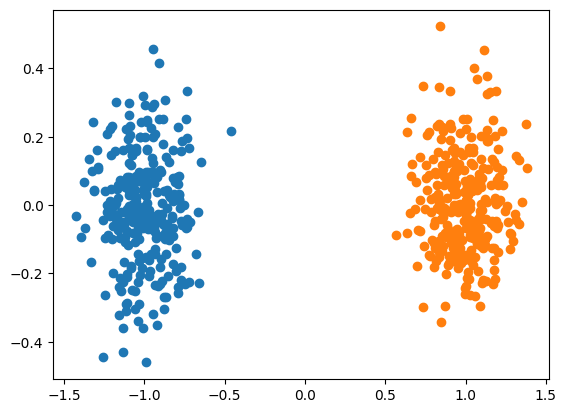

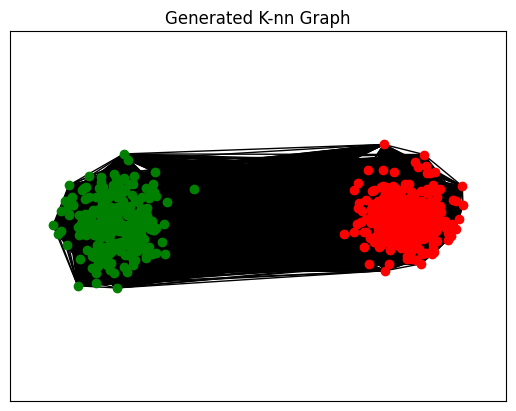

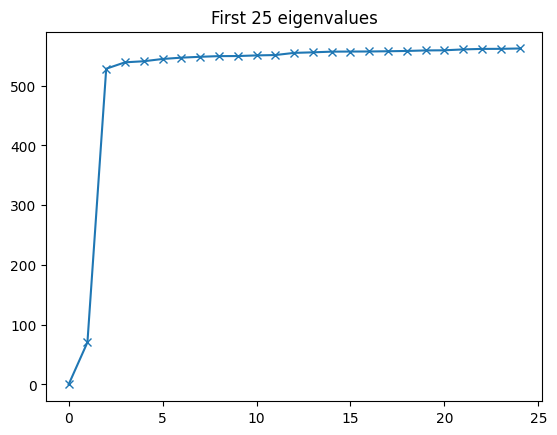

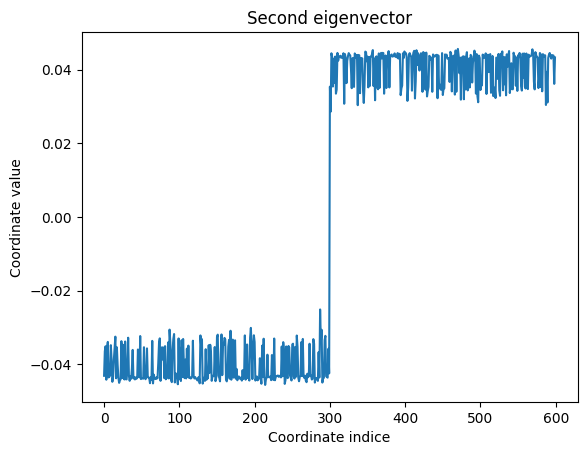

thresholding method: 


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


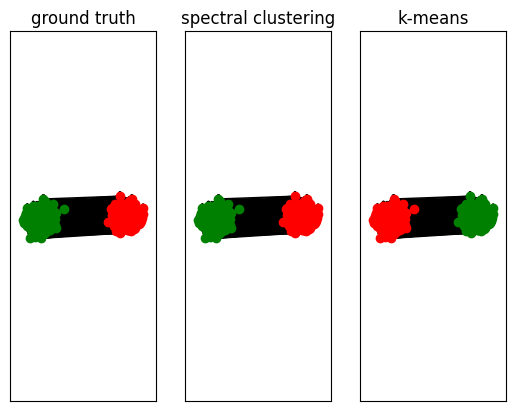

Using built-in K-means: 


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


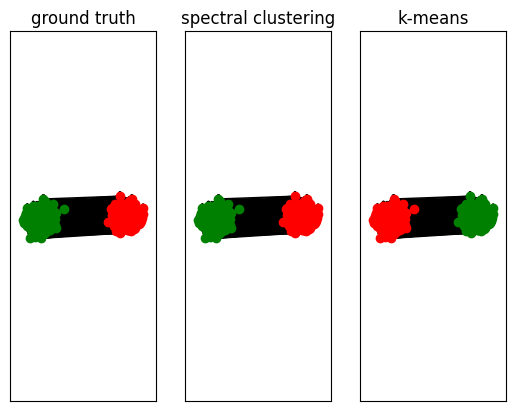

In [ ]:
num_classes = 2

X, Y = blobs(num_samples=600)
print('Blobs Data')
plot_clusters(X, Y)
plt.show()

# k = 400 is higher > nbr samples\ cluster --> connectivity
W = build_similarity_graph(X, k=400)
L = build_laplacian(W)

plot_edges_and_points(X, Y, W, title='Generated K-nn Graph')
plt.show()

eigenvalues, eigenvectors = scipy.linalg.eig(L)
index = eigenvalues.argsort()
eigenvalues = eigenvalues[index].real
U = eigenvectors[:,index].real
E = np.diag(eigenvalues)

plt.plot(eigenvalues[:25] ,marker = 'x')
plt.title("First 25 eigenvalues")
plt.show()

plt.figure()
plt.plot(U[:,1])
plt.title('Second eigenvector')
plt.xlabel('Coordinate indice')
plt.ylabel('Coordinate value')
plt.show()

choosen_eigen_indices = [1]
U = U[:, choosen_eigen_indices]

print('thresholding method: ')

Y_rec = (U>0).astype(int) #Treshold here is 0
plot_clustering_result(X, Y, L, Y_rec, KMeans(num_classes).fit_predict(X))


print('Using built-in K-means: ')
Y_rec = KMeans(num_classes).fit_predict(U)
plot_clustering_result(X, Y, L, Y_rec, KMeans(num_classes).fit_predict(X))


### Q2.2: Build a graph starting from the data generated in `blobs`, but this time make it so that the two components are separated. How do you choose which eigenvectors to use in this case? Motivate your answer.

Here we use a very similar code than below. We put a low value of $k$ to ensure that there is 2 connex components. Notice that in the eigenvalue plot we can see that there is $2$ first eigenvalues equals to $0$ which corresponds to the $2$ connected components. Then I start by investigate the first eigenvector which is here indexed by $0$.
The first eigenvector gives us a perfect clustering result. This is because it captures the most important informations (that there is $2$ clusters).

Blobs Data


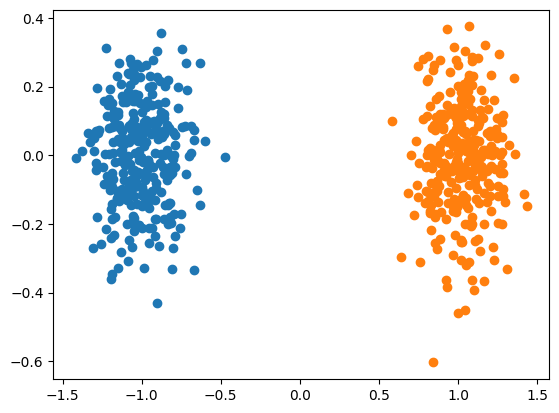

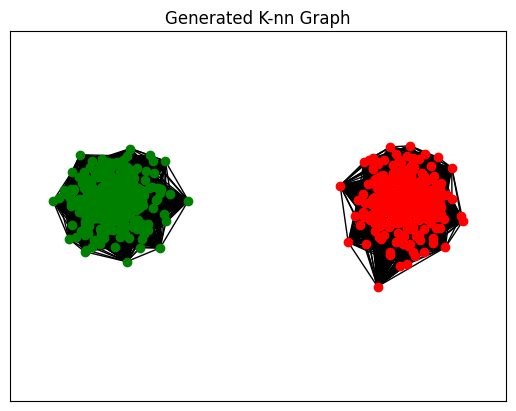

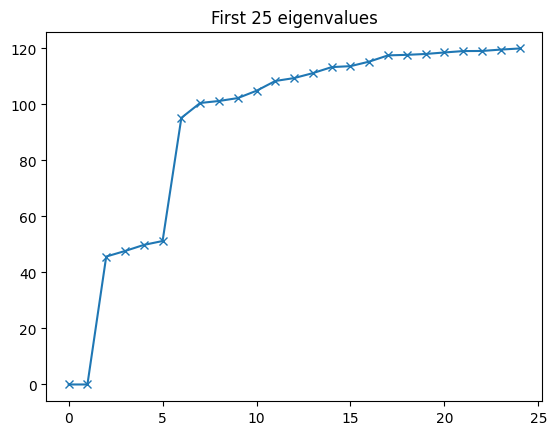

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  Spectral clustering VS KMeans


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


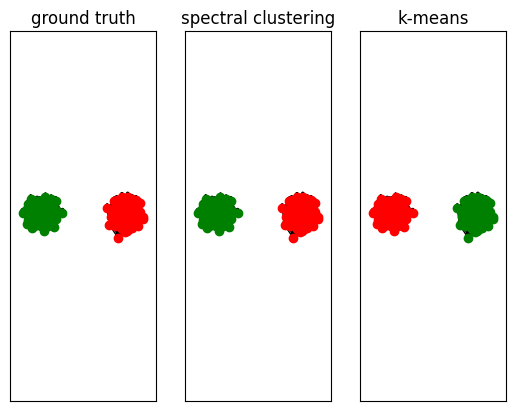

In [ ]:
num_classes = 2

X, Y = blobs(num_samples=600)
print('Blobs Data')
plot_clusters(X, Y)
plt.show()

# k = 100  --> two differents connected components
W = build_similarity_graph(X, k=100)
L = build_laplacian(W)

plot_edges_and_points(X, Y, W, title='Generated K-nn Graph')
plt.show()

eigenvalues, eigenvectors = scipy.linalg.eig(L)
index = eigenvalues.argsort()
eigenvalues = eigenvalues[index].real
U = eigenvectors[:,index].real
E = np.diag(eigenvalues)

plt.plot(eigenvalues[:25] ,marker = 'x')
plt.title("First 25 eigenvalues")
plt.show()

chosen_eig_indices = [1] #Seconde eigenvector choosen
U = U[:, chosen_eig_indices]

Y_rec = KMeans(num_classes).fit_predict(U)

print('  Spectral clustering VS KMeans')
plot_clustering_result(X, Y, L, Y_rec, KMeans(num_classes).fit_predict(X))

### Q2.3: In the function spectral_clustering, implement an automatic strategy to choose the eigenvectors to use for clustering, when chosen_eig_indices=None. Explain your strategy. Generate a dataset with 4 blobs and test your function. What happens when the variance of the blobs increase?

**Strategy number 1**
The strategy is pretty simple, since the eigenvector in the kernel of the unnormalized laplacian matrix carry the topological informations, I decide to use all the eigenvectors corresponding to the eigenvalue $\lambda=0$. Nummerically it corresponds to choose, after sorting eigenvalues, the indices of eigenvector related to eigenvalue close to a treshold (very little and positive).

**Strategy number 2**
During the experiment I also remarked that choosing the eigenvalues equals to the min and the max of those satisfying the elbow rule lead to better clustering in some cases. This why I coded this method in spectral_clustering_bis in the following question.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


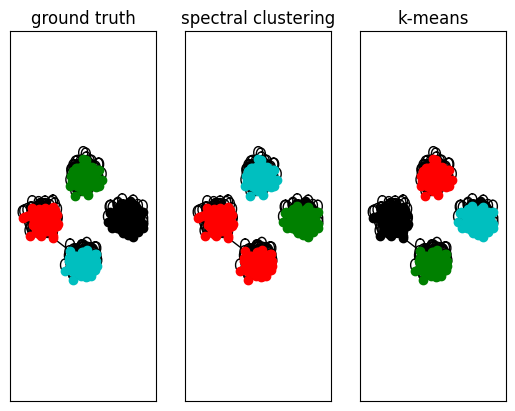

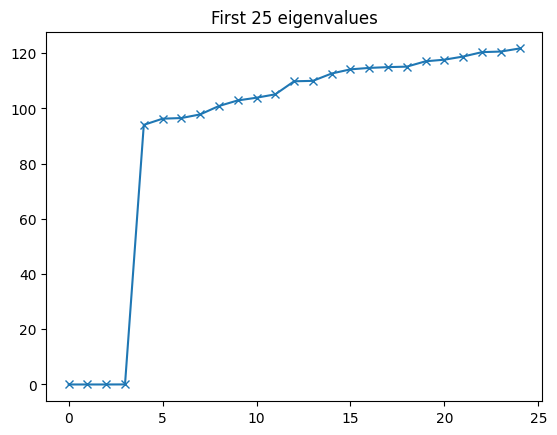

In [ ]:

#Generate data:
X, Y = blobs(num_samples=600, n_blobs=4, blob_var=0.15)
W = build_similarity_graph(X, k=100)
L = build_laplacian(W)
#Sorting procedure
eigenvalues, eigenvectors = scipy.linalg.eig(L)
index = eigenvalues.argsort()
eigenvalues = eigenvalues[index].real
#Clustering
Y_rec = spectral_clustering(L, chosen_eig_indices=None, num_classes=4)
#plotting section
plot_clustering_result(X, Y, L, Y_rec, KMeans(4).fit_predict(X))
plt.plot(eigenvalues[:25] ,marker = 'x')
plt.title("First 25 eigenvalues")
plt.show()

### Q2.4: When you built the cluster assignment, did you use thresholding, k-means or both? Do you have any opinion on when to use each?

I would say, It depends on the data you have.
If I have a noisy data I would use Kmeans since (as we saw previously in the first questions) tresholding is less robust.
Moreover Kmeans is done automatically in the sens that we don't have to choose the treshold and thus make a mistake and get bad clustering. The definition of the treshold is often very delicate and requier some strong hypothesis not always verified.

However tresholding methods are really intersting alternatives for image segmentation for instance, or more generlly on any data you have priori informations about clusters (numbers, caracteristic distance).

### Q2.5: Generate `two_moons` data and compare spectral clustering to k-means. Do you notice any difference? Taking into consideration the graph structure, can you explain them?

We build similarity graph with epsilon treshold and then we compare k means to spectral clustering.

Kmeans fails to cluster correctly the two moons where spectral clustering performs very well (score=0.993).

Notice that some times Kmeans fail if the clusters have different volume or density, which is not the case here. Here, one is rotated relative to the other and there is no significant overlap. So K-means fails because the objective function which it attempts to minimize measures the true clustering solution as worse than (the manifestly) wrong solution we get.

Spectral Clustering VS K-Means


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


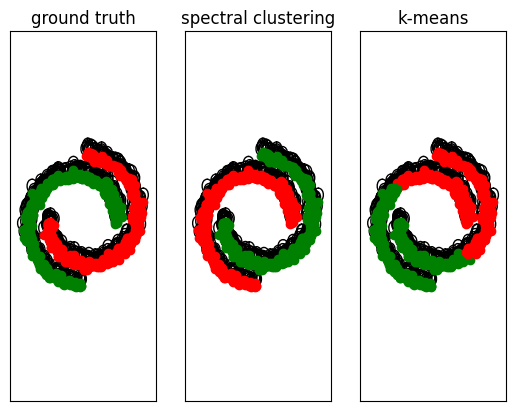

 Spectral clustering  score  =  0.993


In [ ]:
#two_moons?

#Building Similarity graph with epsilon tresholding.
X, Y = two_moons(num_samples=600)
W = build_similarity_graph(X, eps=0.7)
L = build_laplacian(
    W,
)
Y_rec = spectral_clustering(L, num_classes=2, chosen_eig_indices=[1])

print('Spectral Clustering VS K-Means')
plot_clustering_result(X, Y, L, Y_rec, KMeans(2).fit_predict(X))
print(' Spectral clustering  score  = ' , np.round(skm.adjusted_rand_score(Y, Y_rec),3))

### Q2.6: Generate `point_and_circle` data and compare spectral clustering using the normal Laplacian and the random-walk regularized Laplacian. Do you notice any difference? Taking into consideration the graph structure, can you explain them?

Here we can see that in both cases (RW regularized and Unnormalized Laplacian) the spectral clustering outperform Kmeans. In particular spectral clustering is able to separate the central "point" to the torus shape.

Using Random-Walk regularized Laplacian
Clustering score =  1.0


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


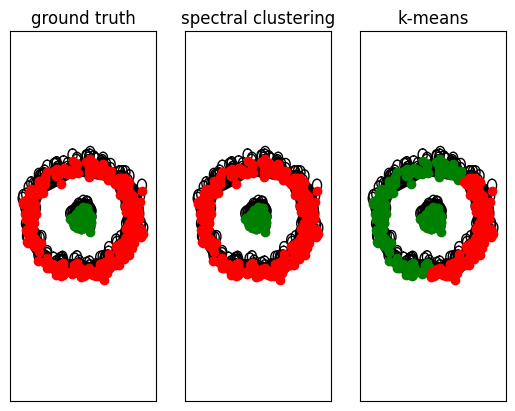

Using unnormalized Laplacian
Clustering score =  1.0


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


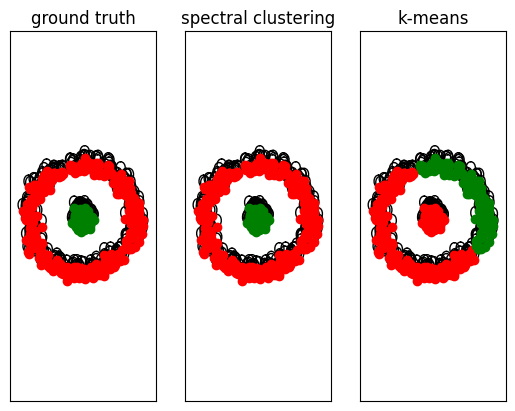

In [ ]:
print('Using Random-Walk regularized Laplacian')
X, Y = point_and_circle(num_samples=600)
W = build_similarity_graph(X, eps=0.6) #epsilon chosen experimentally
L = build_laplacian(W, "rw")
Y_rec = spectral_clustering(L, num_classes=2, chosen_eig_indices=[1])
print('Clustering score = ' , np.round(skm.adjusted_rand_score(Y, Y_rec),3))
plot_clustering_result(X, Y, L, Y_rec, KMeans(2).fit_predict(X))

print('Using unnormalized Laplacian')
X, Y = point_and_circle(num_samples=600)
W = build_similarity_graph(X, eps=0.9) #epsilon chosen experimentally
L = build_laplacian(W, "unn")
Y_rec = spectral_clustering(L, num_classes=2, chosen_eig_indices=[1])
print('Clustering score = ' , np.round(skm.adjusted_rand_score(Y, Y_rec),3))

plot_clustering_result(X, Y, L, Y_rec, KMeans(2).fit_predict(X))




### Q2.7: Using the function parameter_sensitivity, comment on the stability of spectral clustering when varying $\epsilon$ or k.

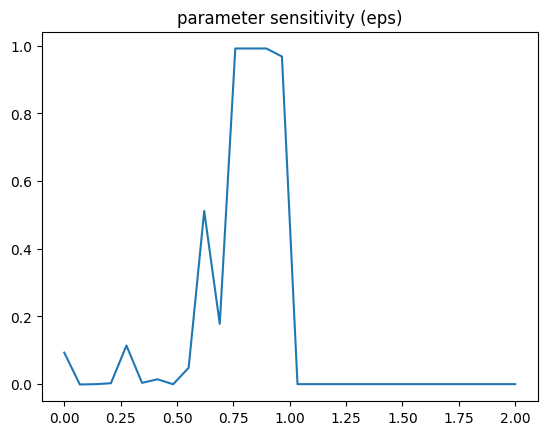

The corresponding epsilon value is 0.759


In [ ]:
parameter_sensitivity()

### Q2.8: If we did not have access to "true" labels, how could we evaluate the clustering result (or what should we not use as evaluation)?

If we don't know the true label it means we are in the unsupervised case.
I would use metrics.
I would use Silhouette Coefficient: It measures how similar an object is to its own cluster, it is number ranged between $-1$ and $1$.
The idea is to have dense clusters regarding an internal criterion.


### Q3.1: Complete all the code necessary, and cluster the `four_elements` and `fruit_salad` images in the data folder and include here some images of the clustering.  Explain your design choices in the overall pipeline (e.g. which graph, which pre-processing...) and how you think they impact the results you are seeing. Report also at least one failure mode for the algorithm.

Here, I decide to use the following heuristic for the choice of the eigenvalues: I choose **the min and max eigenvalue** among those satisfying the **elbow rule**. This led to better clustering results. Therefore I notice the function "spectral_clustering_bis". I also let the paremeter 'k' and the normalization type as parameter in the spectral_clustering_bis function.
"Image_segmentation_bis" is using "spectral_clustering_bis".

In the next four experiments I wanted to show that the choice of eigenvalues is an important step. The four experiments are made with the same parameters except the choice of eigenvalues.
We can see that for the four elements case, both rules **work relatively well**.
However, for the fruit salad case, taking into account all the eigenvalue verifying the elbow rule lead to a **failure** when taking only the max and the min lead to a better results.
In fact, min and max rule is able to distinguish the slice, the segmentation is clearly better.


In [ ]:
def spectral_clustering_bis(L, chosen_eig_indices=None, num_classes=2):
    """
    Parameters
    ----------
    L : numpy array
        Graph Laplacian (standard or normalized)
    choosen_eig_indices : list or None
        Indices of eigenvectors to use for clustering.
        If None, use adaptive choice of eigenvectors.
    num_classes : int
        Number of clusters to compute (defaults to 2)


    Returns
    -------
    Y : numpy array (num_samples, )
        Cluster assignments
    """

    """
    Use the function scipy.linalg.eig or the function scipy.sparse.linalg.eigs to compute:
    U = (n x n) eigenvector matrix           (sorted)
    E = (n x n) eigenvalue diagonal matrix   (sorted)
    """
    """
    compute the clustering assignment from the eigenvectors
    Y = (n x 1) cluster assignments in [0,1,...,num_classes-1]
    """
    E, U = scipy.linalg.eig(L,)
    indices = np.argsort(E.real)
    U = U[:, indices].real
    E = E[indices].real
    #Choose eigenvalues:
    epsilon=0.0001
    if chosen_eig_indices == None:
      index_eigenvalue_min=np.array([np.min(np.where(E<epsilon)[0])])
      index_eigenvalue_max=np.array([np.min(np.where(E<epsilon)[0])])
      chosen_eig_indices=index_eigenvalue_min+index_eigenvalue_max
    """
    compute the clustering assignment from the eigenvectors
    Y = (n x 1) cluster assignments in [0,1,...,num_classes-1]
    """
    # Y = np.zeros(L.shape[0])
    kmeans = KMeans(n_init="auto", n_clusters=num_classes)
    Y = kmeans.fit_predict(U[:, chosen_eig_indices].real)
    return Y

def image_segmentation_bis(input_img='/content/four_elements.bmp',k=2,num_classes = 5, path='unn', eigenvalue_mode=None):

    filename = os.path.join('data', input_img)

    X = io.imread(filename)
    X = (X - np.min(X)) / (np.max(X) - np.min(X))

    im_side = np.size(X, 1)
    Xr = X.reshape(im_side ** 2, 3)
    var = 1
    laplacian_normalization = path
    num_classes = 5
    #epsilon=0.715

    W = build_similarity_graph(Xr, var=var, eps=epsilon, k=k)
    L = build_laplacian(W, laplacian_normalization)

    Y_rec = spectral_clustering_bis(L,chosen_eig_indices=None, num_classes=num_classes)

    plt.figure()

    plt.subplot(1, 2, 1)
    plt.imshow(X)

    plt.subplot(1, 2, 2)
    Y_rec = Y_rec.reshape(im_side, im_side)
    plt.imshow(Y_rec)
    plt.show()


With min+max eigenvalue


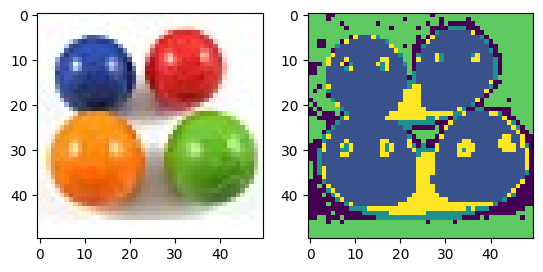

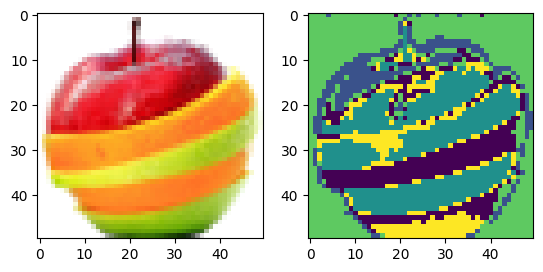

With elbow rule


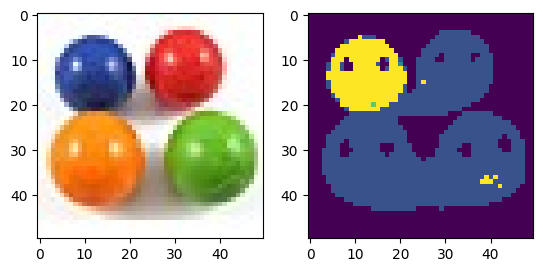

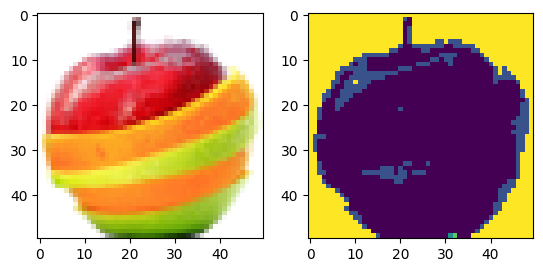

In [ ]:
print('With min+max eigenvalue')
image_segmentation_bis(input_img='/content/four_elements.bmp',k=40,num_classes = 5, path='unn', eigenvalue_mode=None)

image_segmentation_bis(input_img='/content/fruit_salad.bmp',k=40,num_classes = 5, path='unn', eigenvalue_mode=None)

print('With elbow rule')
image_segmentation(input_img='/content/four_elements.bmp')
image_segmentation(input_img='/content/fruit_salad.bmp')


### Q3.2: A full graph built between the pixels of a 50 × 50 image corresponds to $50^2$ nodes. Solving the full eigenvalue problem in this case would scale in the order of $2^{34}$ . Even on weak hardware this takes only seconds to minutes. Segmenting a Full HD picture of 1920 × 1080 would scale in the order of $2^{64}$ (about a month on a decent machine). Beyond that, the large picture would require to store in memory a graph over millions of nodes. A full graph on that scale requires about 1TB of memory. Can you think two simple techniques to reduce the computational and occupational cost of Spectral Clustering?

My first idea (surely not the clever one) would be to use dimensionality reduction methods such as PCA to reduce the number of dimensions per data point, decreasing the size of the similarity matrix and thus reducing computational load and memory usage.

My second idea would be to implement a sparse graph.
Like the k-nearest neighbors or epsilon-neighborhood graph, to significantly cut down on the number of edges in the graph. This leads to a smaller and more manageable adjacency matrix.

### Q3.3: Choose a larger image of your choice, and try to implement some of the scalability modifications to run spectral clustering on it. Report some examples of the results you achieve.

The problem with larger image is that we reach the **curse of the dimensionality**.  So I tried to use reduction dimension techniques.
The first one I tried was PCA however even if I keep one component this is not enough.
So I inspired from the image proposed and I noticed that the quality of this image was very low so using a technique from another course of the MVA: the subsampling. The goal is to reduce image size and resolution while preserving essential visual characteristics.
I reduce the quality of this image then I made spectrale clustering on it.

I used the spectral_clustering_bis to do the clustering this gives better results (higher silhouette score)

In [ ]:
from PIL import Image
jpg_filname='/content/bubble_tea.tiff'
img=Image.open(jpg_filname)

bmp_filename='converted_bubble.bmp'
img.save(bmp_filename)

In [ ]:
path = '/content/converted_bubble.bmp'
image = Image.open(path)
subsample_factor = 3
image_subsampled= image.resize((image.width // subsample_factor, image.height // subsample_factor), Image.LANCZOS)
image_resized=image_subsampled.resize((50,50))

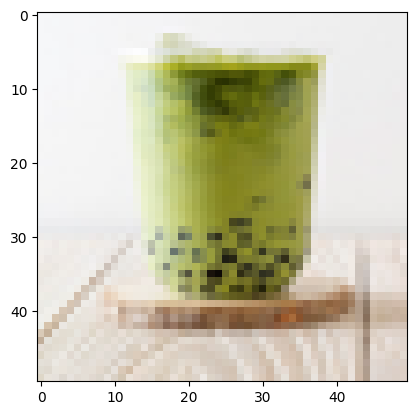

In [ ]:
plt.imshow(image_resized)

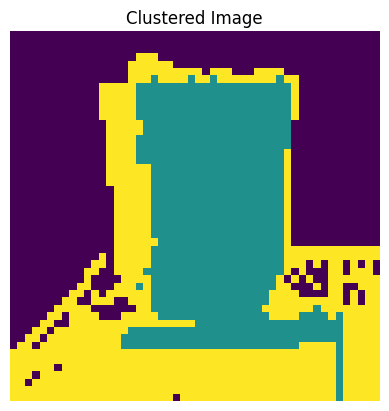

the silouhette score is equal to 0.583


In [ ]:
from sklearn.metrics import silhouette_score
X=np.array(image_resized)/255
X=(X - np.min(X)) / (np.max(X) - np.min(X))
im_side = np.size(X, 1)
Xr = X.reshape(im_side ** 2, 3)
W = build_similarity_graph(Xr, var=1, eps=0,k=50)
# Construction du Laplacien
L = build_laplacian(W)

# Clustering spectral
Y_rec = spectral_clustering_bis(L, None, num_classes=3) #None to choose automatically the eigenvalues
Y_rec = Y_rec.reshape(im_side, im_side)
plt.imshow(Y_rec)

plt.title('Clustered Image')
plt.axis('off')
plt.show()

#Score calculation using Silhouette metric :
pixels=X.reshape(-1,X.shape[-1])
Y_rec = spectral_clustering_bis(L, None, num_classes=3)
score=silhouette_score(pixels,Y_rec)

print(f'the silouhette score is equal to {np.round(score,3)}')